# A575 Homework 2
-Armaan Goyal

In [443]:
#basic packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy

#specific tasks and routines
from matplotlib.offsetbox import AnchoredText
from scipy.integrate import quad
from scipy.optimize import least_squares

#plotting and LaTeX
from astropy.visualization import astropy_mpl_style
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"]=100
%config InlineBackend.figure_format = "svg"
plt.rcParams["text.usetex"] =True

In [444]:
#define sersic profile and residual function
def sersic(x, r):
    return x[0] + 1.086*(r/x[1])**x[2]
    
def fun(x, r_train, mu_train):
    return sersic(x, r_train) - mu_train

#read and unpack data from .dat files
def data_from_text(filename):
    data = np.genfromtxt(filename, unpack = True)
    r, mag, mu, col, colmag, colerr, ell  = data[1], data[2], data[4], data[5], data[6], data[7], data[8]
    return r, mag, mu, col, colmag, colerr, ell

In [473]:
# main task
# enter either "dE" or "dI" as gal_type
# iterates through .dat files for given type and performs fits with option to save plots

def fit_sersic(gal_type, show = False, save = False):
    #read data into dataframe
    file = "A575_" + gal_type + "/galaxies.list"
    gal_key = "galaxy"
    if gal_type == "dI":
        gal_key = "Galaxy"
    df = pd.read_fwf(file)
    df = df.set_index(gal_key)
    gals = df.index.values.tolist()
    
    #initialize raw data lists
    ell_list = []
    app_list = []
    colmag_list = []
    abs_list = []
    corr_mag_list = []
    
    #initialize fit parameter lists
    mu0_list = []
    Rd_list = []
    Rdphys_list = []
    n_list = []

    for gal in gals:
        #read data
        if gal_type == "dE":
            filename = gal.replace("vcc", "v")
            filename = "A575_dE/" + filename + "br.dat"
        if gal_type == "dI":
             filename = "A575_dI/" + gal + "bv.dat"
        r, mag, mu, col, colmag, colerr, ell = data_from_text(filename)
        
        # correct surface brightness values
        mu_B = mu + col
        ext = df.loc[gal]['A_B']
        mu_ext = mu_B - ext
        med_ell = np.median(ell)
        inc_corr = -2.5*np.log10(1-med_ell)
        mu_ext_inc = mu_ext + inc_corr
    
        # correct magnitude values
        app = mag[-1]
        br = colmag[-1]
        dist_key = "Dist"
        if gal_type == "dI":
            dist_key += "ance"
        dist = df.loc[gal][dist_key]
        app_corr = app + br - ext - 2.5*np.log10(1-med_ell)
        abs_mag = app_corr + 5 - 5*np.log10(dist*1e6)
        
        #append raw/corrected data to lists
        app_list.append(app)
        colmag_list.append(br)
        abs_list.append(abs_mag)
        corr_mag_list.append(app_corr)

        # fitting
        x0 = [21.7, 3, 1]
        res_robust = least_squares(fun, x0, loss='linear', args=(r, mu_ext_inc))
        params = res_robust.x
        mu0, Rd, n = params[0], params[1], params[2]
        Rdphys = (dist*1e3)*(Rd/206264.806)
    
        # append fit parameters to lists
        mu0_list.append(mu0)
        Rd_list.append(Rd)
        n_list.append(n)
        ell_list.append(avg_ell)
        Rdphys_list.append(Rdphys)

        # plotting
        fig, ax = plt.subplots(figsize=(5,5))
        textstr = '$\mu_{0}=%.2f$ mag/arcsec$^{2}$  \n $R_{d}=%.2f$ kpc \n $n=%.2f$'%(mu0, Rdphys, n)
        props = dict(alpha=0)
        
        ax.text(0.05, 0.20, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
        ax.text(0.6, 0.8, gal, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
    
        ax.plot(r, sersic(params, r), c = "black", ls = "--")
        ax.errorbar(r, mu_ext_inc, yerr=colerr, fmt="none", capsize=1)
        ax.scatter(r, mu_ext_inc, label = "Corrected B-Band Data")
        ax.invert_yaxis()
        ax.set_ylabel("Corrected Surface Brightness [mag/arcsec$^{2}$]")
        ax.set_xlabel("Galactic Semi-Major Axis [arcsec]")
        if show:
            plt.show()
        if save:
            fig.savefig(gal+"fit")
            
    # fill output dataframes
    df["app_mag"] = app_list
    df["colmag"] = colmag_list
    df['ell'] = ell_list
    df["corrmag"] = corr_mag_list
    df["absmag"] = abs_list
    df["mu0"] = mu0_list
    df["Rd"] = Rd_list
    df["Rd_phys"] = Rdphys_list
    df["n"] = n_list
        
    #round values and split data frame
    df = df.round(3)
    df_raw = df.iloc[:,:7] 
    df_fit = df.iloc[:,7:] 
        
    return df_raw, df_fit

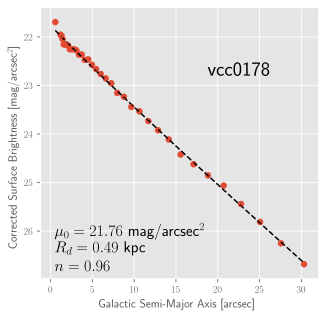

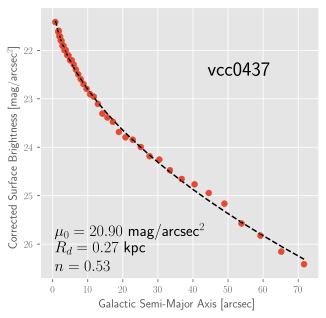

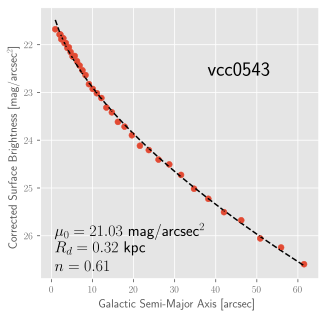

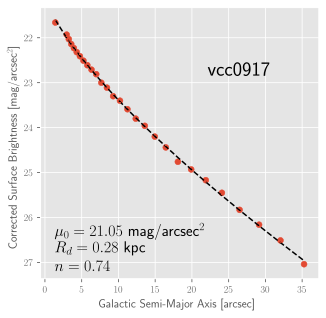

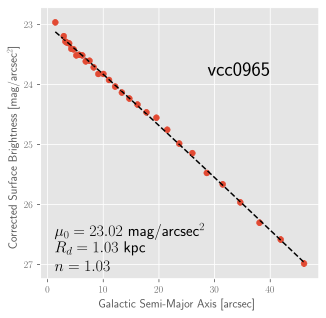

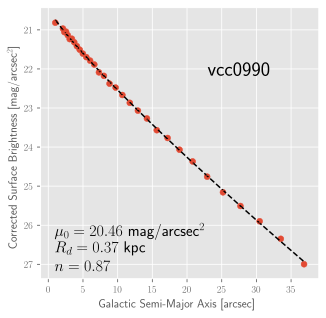

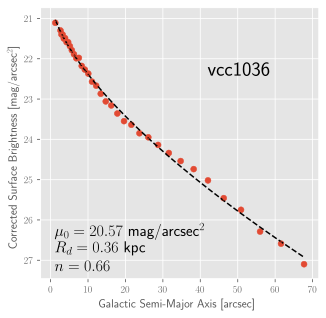

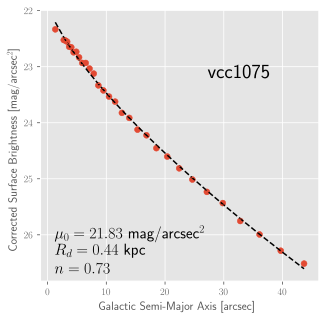

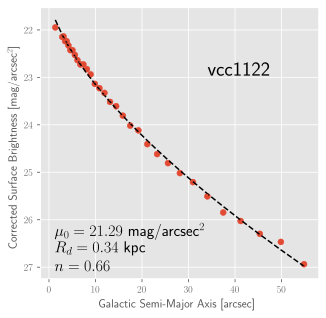

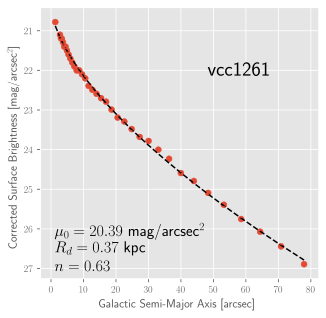

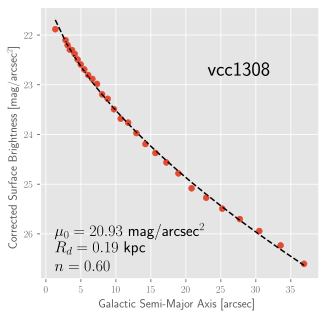

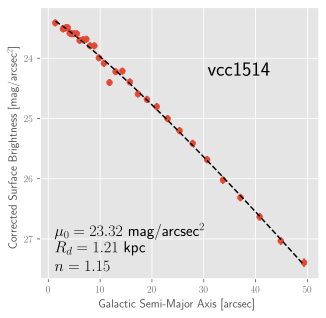

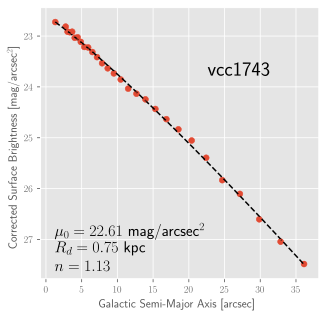

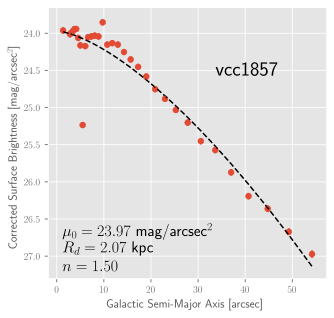

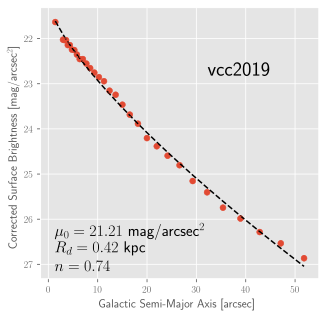

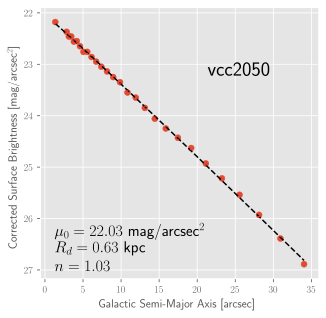

In [474]:
# ellipticals
dE_raw, dE_fit = fit_sersic("dE")

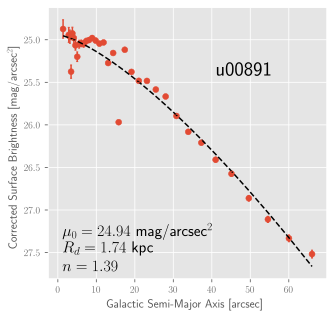

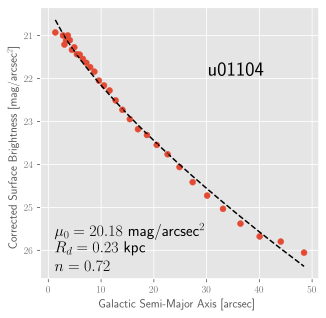

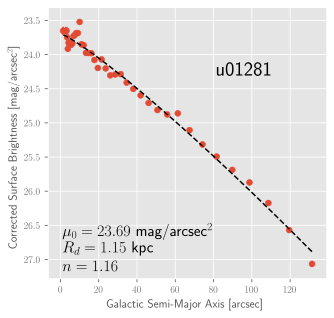

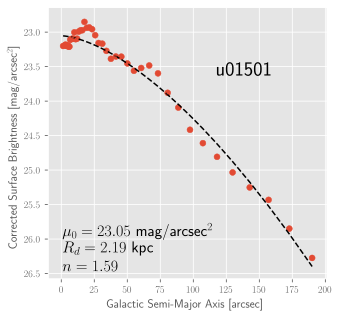

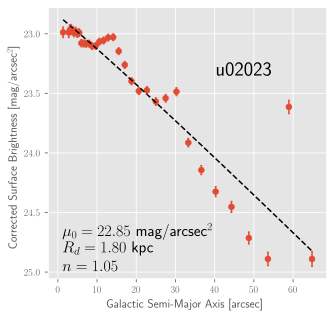

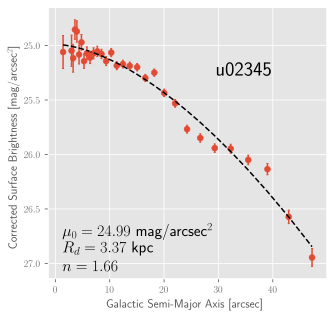

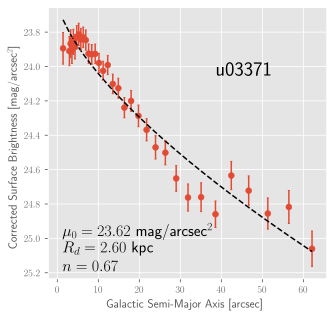

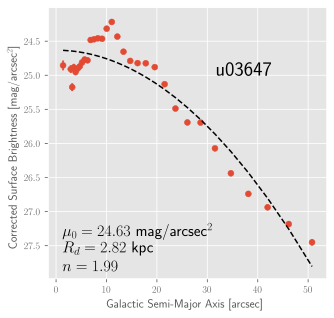

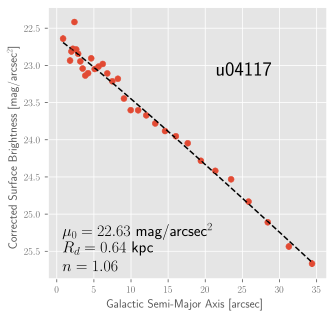

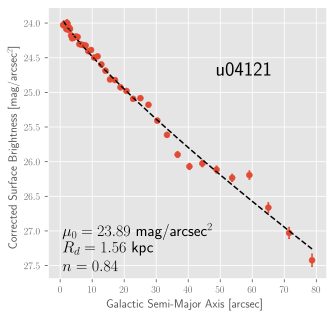

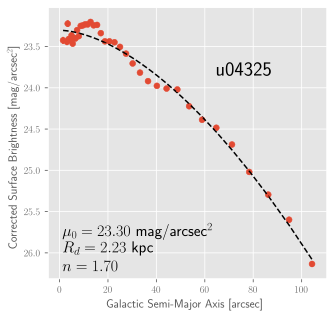

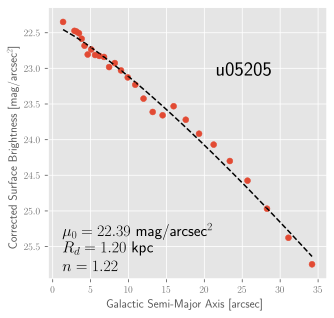

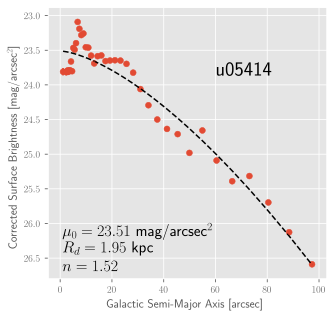

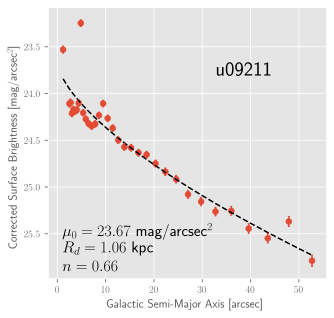

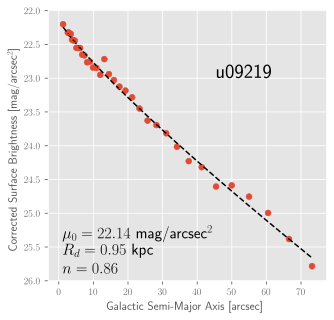

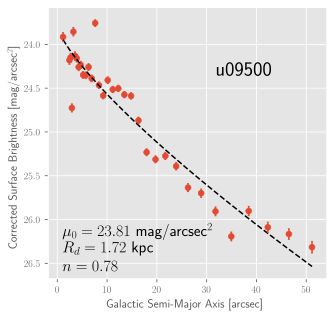

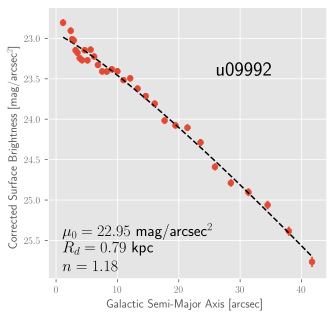

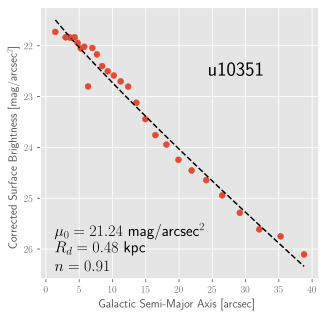

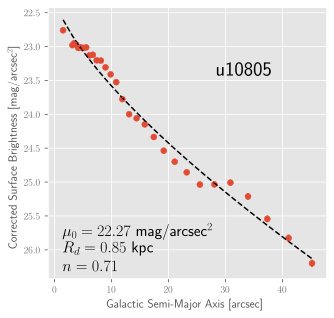

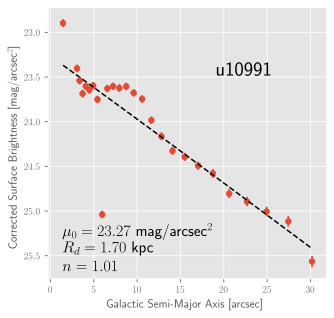

In [475]:
# irregulars
dI_raw, dI_fit = fit_sersic("dI")

In [476]:
dE_raw

,Dist,A_B,app_mag,colmag,ell,corrmag,absmag
galaxy,,,,,,,
vcc0178,16.1,0.15,14.561,1.336,0.336,16.310,-14.724
vcc0437,16.1,0.13,13.119,1.348,0.336,14.692,-16.342
vcc0543,16.1,0.14,13.368,1.333,0.336,15.177,-15.857
vcc0917,16.1,0.14,14.439,1.319,0.336,16.269,-14.765
vcc0965,16.1,0.13,14.532,1.292,0.336,16.458,-14.576
vcc0990,16.1,0.12,13.572,1.355,0.336,15.174,-15.860
vcc1036,16.1,0.12,12.881,1.357,0.336,14.936,-16.098
vcc1075,16.1,0.12,14.176,1.299,0.336,15.789,-15.245
vcc1122,16.1,0.09,13.903,1.276,0.336,15.916,-15.118


In [477]:
dI_raw

,Distance,A_B,app_mag,colmag,ell,corrmag,absmag
Galaxy,,,,,,,
u00891,10.52,0.14,14.412,0.493,0.336,17.178,-12.932
u01104,11.11,0.27,13.976,0.496,0.336,14.720,-15.509
u01281,4.58,0.21,13.222,0.472,0.336,15.511,-12.793
u01501,4.83,0.24,12.053,0.460,0.336,13.546,-14.874
u02023,10.17,0.38,13.738,0.537,0.336,13.976,-16.061
u02345,20.30,0.24,14.495,0.494,0.336,16.937,-14.601
u03371,13.38,0.64,14.683,0.683,0.336,14.948,-15.684
u03647,19.67,0.26,14.418,0.496,0.336,16.737,-14.732
u04117,10.03,0.19,15.182,0.339,0.336,16.230,-13.777


In [478]:
dE_fit

,mu0,Rd,Rd_phys,n
galaxy,,,,
vcc0178,21.758,6.322,0.493,0.961
vcc0437,20.901,3.485,0.272,0.531
vcc0543,21.034,4.109,0.321,0.606
vcc0917,21.052,3.543,0.277,0.737
vcc0965,23.017,13.211,1.031,1.033
vcc0990,20.463,4.749,0.371,0.871
vcc1036,20.569,4.572,0.357,0.656
vcc1075,21.833,5.668,0.442,0.725
vcc1122,21.286,4.387,0.342,0.656


In [479]:
dI_fit

,mu0,Rd,Rd_phys,n
Galaxy,,,,
u00891,24.941,34.091,1.739,1.389
u01104,20.176,4.352,0.234,0.723
u01281,23.691,51.794,1.150,1.159
u01501,23.053,93.674,2.194,1.591
u02023,22.849,36.600,1.805,1.046
u02345,24.989,34.205,3.366,1.665
u03371,23.615,40.013,2.596,0.675
u03647,24.631,29.599,2.823,1.988
u04117,22.632,13.069,0.635,1.056


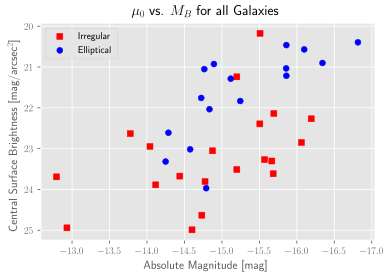

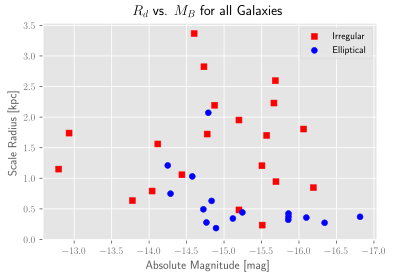

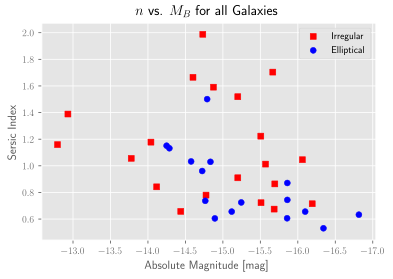

In [480]:
# plot fit parameters vs. absolute magnitude for all galaxies

fig = plt.figure()
plt.scatter(np.array(dI_raw["absmag"]), np.array(dI_fit["mu0"]), color = "red", label = "Irregular", marker = "s")
plt.scatter(np.array(dE_raw["absmag"]), np.array(dE_fit["mu0"]), color = "blue", label = "Elliptical")
plt.xlabel("Absolute Magnitude [mag]")
plt.ylabel("Central Surface Brightness [mag/arcsec$^{2}$]")
plt.title("$\mu_{0}$ vs. $M_{B}$ for all Galaxies")
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.legend()
plt.show()
fig.savefig("mu0_Rd")

fig = plt.figure()
plt.title("$R_{d}$ vs. $M_{B}$ for all Galaxies")
plt.scatter(np.array(dI_raw["absmag"]), np.array(dI_fit["Rd_phys"]), color = "red", label = "Irregular", marker = "s")
plt.scatter(np.array(dE_raw["absmag"]), np.array(dE_fit["Rd_phys"]), color = "blue", label = "Elliptical")
plt.xlabel("Absolute Magnitude [mag]")
plt.ylabel("Scale Radius [kpc]")
plt.gca().invert_xaxis()
plt.legend()
plt.show()
fig.savefig("n_Rd")

fig = plt.figure()
plt.title("$n$ vs. $M_{B}$ for all Galaxies")
plt.scatter(np.array(dI_raw["absmag"]), np.array(dI_fit["n"]), color = "red", label = "Irregular", marker = "s")
plt.scatter(np.array(dE_raw["absmag"]), np.array(dE_fit["n"]), color = "blue", label = "Elliptical")
plt.xlabel("Absolute Magnitude [mag]")
plt.ylabel("Sersic Index")
plt.gca().invert_xaxis()
plt.legend()
fig.savefig("n_mu0")
plt.show()